In [1]:
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
from drn_interactions.config import Config
from drn_interactions.io import load_derived_generic
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu
from drn_interactions.stats import mannwhitneyu_plusplus

sns.set_theme(style="ticks", context="paper")

In [7]:
fig_dir = Config.fig_dir

pop = (
    load_derived_generic("decoding/brain state - pop.csv")
    .rename(columns=dict(pop_true="Population", shuffle="Shuffle"))
)
unit = load_derived_generic("decoding/brain state - unit.csv")
limit = load_derived_generic("decoding/brain state - limit.csv")
dropout = load_derived_generic("decoding/brain state - dropout.csv")

pop = (
    unit
    .groupby("session_name")["F1 Score"].max()
    .to_frame("Best Neuron")
    .reset_index()
    .merge(pop, on="session_name")
    .melt(id_vars="session_name", var_name="metric", value_name="value")
    .assign(metric = lambda x: pd.Categorical(x.metric, categories=["Population", "Best Neuron", "Shuffle"]))
)

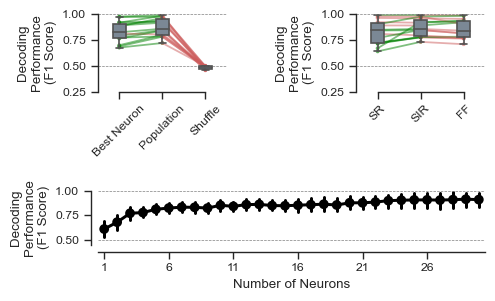

In [9]:
f = plt.figure(figsize=(5, 3))

axes = f.subplot_mosaic([["A", "B"], ["C", "C"]], gridspec_kw=dict(height_ratios=[1, 0.7]))

ax_box = axes["A"]
ax_box.set_ylim(0.25, 1)
ax_box.set_yticks([0.25, 0.5, 0.75, 1])
pg.plot_paired(
    data=pop, 
    dv="value", 
    subject="session_name", 
    within="metric", 
    boxplot_in_front=True,
    pointplot_kwargs=dict(alpha=0.5),
    boxplot_kwargs=dict(width=0.3),
    ax=ax_box,
    )

ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=45)
ax_box.set_ylabel("Decoding\nPerformance\n(F1 Score)")
# ax_box.set_title("Decoder\nPerformance", pad=20)
ax_box.set_xlabel("")
ax_box.axhline(0.5, color="grey", linewidth=0.5, linestyle="--")
ax_box.axhline(1, color="grey", linewidth=0.5, linestyle="--")
##

ax_box2 = axes["B"]
ax_box2.set_ylim(0.25, 1)
ax_box2.set_yticks([0.25, 0.5, 0.75, 1])
pg.plot_paired(
    data=dropout, 
    dv="score", 
    subject="session_name", 
    within="dropped", 
    boxplot_in_front=True,
    pointplot_kwargs=dict(alpha=0.5),
    boxplot_kwargs=dict(width=0.3),
    ax=ax_box2,
    order=["SR", "SIR", "FF"]
    )

ax_box2.set_xticklabels(ax_box2.get_xticklabels(), rotation=45)
ax_box2.set_ylabel("Decoding\nPerformance\n(F1 Score)")
ax_box2.set_xlabel("")
ax_box2.axhline(0.5, color="grey", linewidth=0.5, linestyle="--")
ax_box2.axhline(1, color="grey", linewidth=0.5, linestyle="--")

ax_line = axes["C"]
ax_line.set_ylim(0.45, 1)
ax_line.set_yticks([0.5, 0.75, 1])

sns.pointplot(data=limit, x="n_neurons", y="pop_score", ax=ax_line, color="black")

ax_line.xaxis.set_major_locator(plt.MultipleLocator(5))
ax_line.set_ylabel("Decoding\nPerformance\n(F1 Score)")
ax_line.set_xlabel("Number of Neurons")
ax_line.axhline(0.5, color="grey", linewidth=0.5, linestyle="--")
ax_line.axhline(1, color="grey", linewidth=0.5, linestyle="--")
f.subplots_adjust(wspace=1, hspace=1.5)
sns.despine(fig=f)
sns.despine(ax=ax_line, offset=5)

f.savefig(fig_dir / "bs - decoding_performance_box_line.png", bbox_inches="tight", dpi=300)


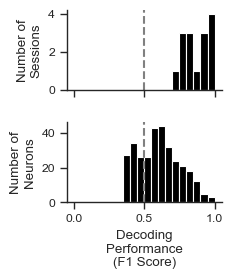

In [4]:
f = plt.figure(figsize=(2, 2.5))

ax_session, ax_neurons = f.subplots(2, 1, sharex=True)

bins = np.arange(0, 1.05, 0.05)

ax_session.hist(
    pop.query("metric == 'Population'")["value"], 
    bins=bins, 
    color="black"
    )
ax_session.axvline(0.5, color="grey", linewidth=1.5, linestyle="--")


ax_neurons.hist(
    unit["F1 Score"], 
    bins=bins, 
    color="black"
    )
ax_neurons.axvline(0.5, color="grey", linewidth=1.5, linestyle="--")
ax_session.set_ylabel("Number of\nSessions")
ax_neurons.set_ylabel("Number of\nNeurons")

ax_neurons.set_xlabel("Decoding\nPerformance\n(F1 Score)")

f.subplots_adjust(hspace=0.4)
sns.despine(fig=f)
f.savefig(fig_dir / "bs - decoding_performance_hist.png", bbox_inches="tight", dpi=300)


In [23]:
# encoding

pop = (
    load_derived_generic("encoding/brain state - pop.csv")
    .rename(columns=dict(pop="Population"))
    .merge(
        load_derived_generic("encoding/brain state - pop shuffle.csv").rename(columns=dict(pop="Population\nShuffle")),
         on=["neuron_id", "session_name"])
)
state = (
    load_derived_generic("encoding/brain state - state.csv").rename(columns=dict(state="State"))
    .rename(columns=dict(pop="Population"))
    .merge(
        load_derived_generic("encoding/brain state - state shuffle.csv").rename(columns=dict(state="State\nShuffle")),
         on=["neuron_id", "session_name"])
)
state_pop = pd.concat(
    [state.melt(id_vars=["neuron_id", "session_name"]),
    pop.melt(id_vars=["neuron_id", "session_name"]),]
).reset_index()

limit = load_derived_generic("encoding/brain state - limit.csv")
dropout = load_derived_generic("encoding/brain state - dropout.csv")



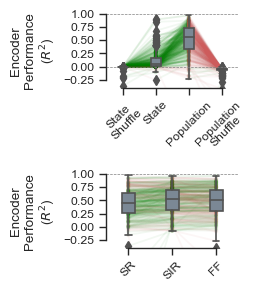

In [24]:
f = plt.figure(figsize=(2.6, 3))

ax_box, ax_box2 = f.subplots(2, 1, sharex=False)


ax_box.set_ylim(-0.4, 1)
ax_box.set_yticks([-0.25, 0, 0.25, 0.5, 0.75, 1])
pg.plot_paired(
    data=state_pop, 
    dv="value", 
    subject="neuron_id", 
    within="variable", 
    boxplot_in_front=True,
    pointplot_kwargs=dict(alpha=0.05),
    boxplot_kwargs=dict(width=0.3),
    ax=ax_box,
    order=["State\nShuffle", "State", "Population", "Population\nShuffle"]
    )

ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=45)
ax_box.set_ylabel("Encoder\nPerformance\n($R^{2}$)")
ax_box.set_xlabel("")
ax_box.axhline(0, color="grey", linewidth=0.5, linestyle="--")
ax_box.axhline(1, color="grey", linewidth=0.5, linestyle="--")

##

ax_box2.set_ylim(-0.4, 1)
ax_box2.set_yticks([-0.25, 0, 0.25, 0.5, 0.75, 1])
pg.plot_paired(
    data=dropout, 
    dv="score", 
    subject="neuron_id", 
    within="neuron_type", 
    boxplot_in_front=True,
    pointplot_kwargs=dict(alpha=0.05),
    boxplot_kwargs=dict(width=0.3),
    ax=ax_box2,
    order=["SR", "SIR", "FF"]
    )

ax_box2.set_xticklabels(ax_box2.get_xticklabels(), rotation=45)
ax_box2.set_ylabel("Encoder\nPerformance\n($R^{2}$)")
ax_box2.set_xlabel("")
ax_box2.axhline(1, color="grey", linewidth=0.5, linestyle="--")


#####


f.subplots_adjust(hspace=1.5)
f.tight_layout()

f.savefig(fig_dir / "bs - encoding_performance_box.png", bbox_inches="tight", dpi=300)


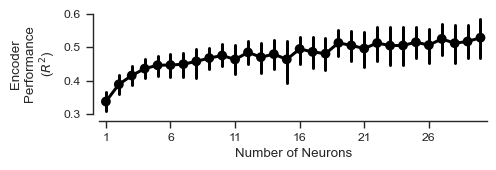

In [27]:
f = plt.figure(figsize=(5, 1.3))
ax_line = f.subplots()

ax_line.set_ylim(0.3, 0.6)

sns.pointplot(data=limit, x="n_best", y="score", ax=ax_line, color="black")

ax_line.xaxis.set_major_locator(plt.MultipleLocator(5))
ax_line.set_ylabel("Encoder\nPerformance\n($R^{2}$)")
ax_line.set_xlabel("Number of Neurons")

# sns.despine(fig=f)
sns.despine(ax=ax_line, offset=5)

f.savefig(fig_dir / "bs - encoding_performance_line.png", bbox_inches="tight", dpi=300)
